## Annualized basis yield for ETH futures ##

Author: Alexis Plascencia  aplascenciac@gmail.com

Downloads the ETH futures data using the Deribit API. \
Calculates the annualized yield for each contract. \
Generates plot of the annualized yield for the future contracts.

In [ ]:
import requests
import pandas as pd
import matplotlib.pylab as plt
import matplotlib

from datetime import datetime, timedelta

In [ ]:
def get_futures_data():
  """Connects to the Deribit API and gets the data on ETH Futures

  Returns:
      futures_data: Dictionary with the information on ETH Futures
  """

  token = 'ETH'
  r_summ = requests.get('https://test.deribit.com/api/v2/public/get_book_summary_by_currency?currency=' + token + '&kind=future')
  summary = r_summ.json()
  return summary

futures_data = get_futures_data()

In [ ]:
def get_price_expiry(futures_data):
  """Creates two lists with the name and price of each contract

  Arguments:
      futures_data: Dictionary with the information of the ETH futures

  Returns:
      title: List with the names of the future contract
      price: List with the price of each contract
  """

  num_futures = len(futures_data['result'])
  title = []
  price = []
  for i in range(num_futures):

    title.append(futures_data['result'][i]['instrument_name'])

    # The ETH/USD price is obtained from 'estimated_delivery_price' in the ETH Perpetual
    # an alternative is to access 'get_index_price?index_name=eth_usd'
    if futures_data['result'][i]['instrument_name'] == 'ETH-PERPETUAL':
      price.append(futures_data['result'][i]['estimated_delivery_price'])
    else:
      price.append(futures_data['result'][i]['mid_price'])

  return [title, price]


[title, price] = get_price_expiry(futures_data)

In [ ]:
def get_expiry_dates(title):
  """Obtain the expiry dates for each contract and saves it in 'datetime' format

  Arguments:
      title: List with the names of the future contract

  Returns:
      expiry_dates: List with the expiry date of each contract
  """
  expiry_dates = []

  for i in range(len(title)):
    end = len(title[i])

    # We obtain the expiry date
    date_string = title[i][4:end]

    if date_string == 'PERPETUAL':
      expiry_dates.append(datetime.utcnow())
    else:
      # The Futures contract expire at 08:00 UTC
      expiry_dates.append(datetime.strptime(date_string, "%d%b%y")+ timedelta(hours=8))

  return expiry_dates

expiry_dates = get_expiry_dates(title)

In [ ]:
# We construct the Dataframe with the contracts, price and expiry date
df = pd.DataFrame({"Name": title})
df["Price"] = price
df["Expiry Date"] = expiry_dates
df = df.sort_values(by="Expiry Date")
df = df.reset_index(drop=True)

In [ ]:
# Calculation of the anualized yield
delta_days = []
yield_annual = []
eth_price = df['Price'][0]
print('The current ETH price is: ', eth_price)

for i in range(len(title)):
    diff = df['Expiry Date'][i]-df['Expiry Date'][0]
    delta = diff.days + diff.seconds/86400.
    delta_days.append(delta)
    yield_annual.append(100.*(df['Price'][i]-eth_price)/eth_price*(365./(delta+0.0001)))

# Add new columns to dataframe
df['Days to Expiry'] = delta_days
df["Yield % (annual)"] = yield_annual

# Drop the Perpetual future
df = df.drop(axis=0,index=0)

The current ETH price is:  3507.65


In [ ]:
# We show the dataframe that contais the results:
df

,Name,Price,Expiry Date,Days to Expiry,Yield % (annual)
1,ETH-8MAR24,3520.88,2024-03-08 08:00:00,3.840301,35.847584
2,ETH-15MAR24,3539.63,2024-03-15 08:00:00,10.840301,30.697975
3,ETH-29MAR24,3564.00,2024-03-29 08:00:00,24.840301,23.605431
4,ETH-26APR24,3621.63,2024-04-26 08:00:00,52.840301,22.446010
5,ETH-28JUN24,3716.38,2024-06-28 08:00:00,115.840301,18.750007
6,ETH-27SEP24,3805.75,2024-09-27 08:00:00,206.840301,14.996959
7,ETH-27DEC24,3888.75,2024-12-27 08:00:00,297.840301,13.314717


**Plot for the annual yield (%) for each of the ETH futures contract:**

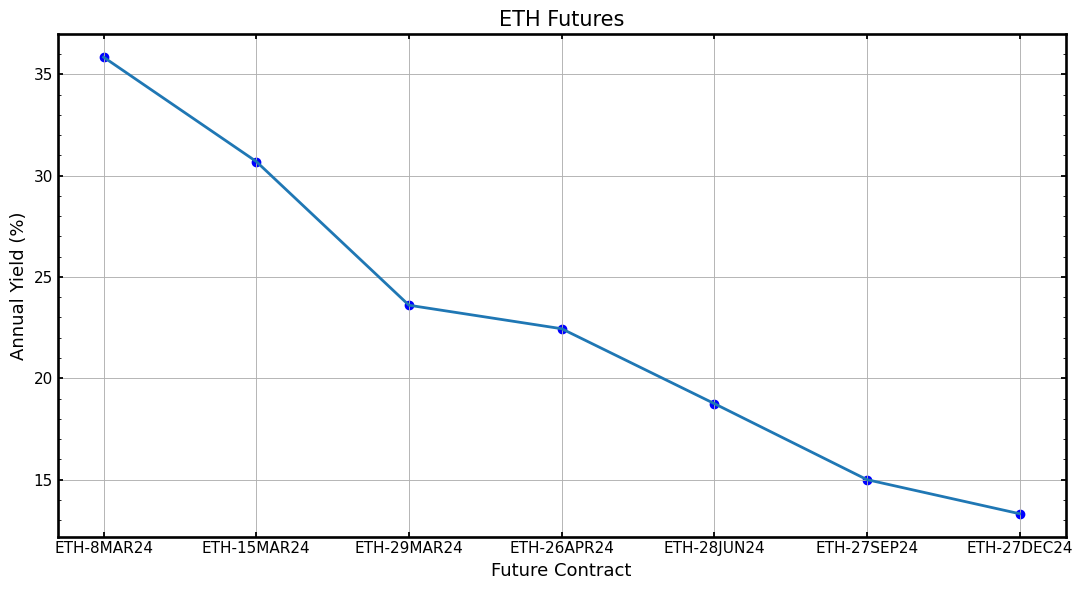

In [ ]:
def make_yield_plot():
  matplotlib.rcParams['axes.linewidth'] = 1.9
  fig = plt.figure(figsize=(11,6))
  ax = fig.gca()
  ax.yaxis.set_minor_locator(plt.MultipleLocator(1))
  ax.tick_params(axis='both', which='both', direction='in', labelsize=11)
  ax.set_xlabel('Future Contract', fontsize=13)
  ax.set_ylabel('Annual Yield (%)', fontsize=13)

  plt.plot(df["Name"], df["Yield % (annual)"],color='tab:blue', linewidth=2)
  plt.scatter(df["Name"], df["Yield % (annual)"], color='blue')
  ax.set_title('ETH Futures', fontsize=15, color='black')
  ax.grid(linewidth=0.65)

  ax.xaxis.set_tick_params(width=1.3)
  ax.yaxis.set_tick_params(width=1.3)

  plt.tight_layout()
  ax.xaxis.set_ticks_position('both')
  ax.yaxis.set_ticks_position('both')
  plt.show()
  fig.savefig('yield.png')
  fig.savefig('yield.pdf', format='pdf')

make_yield_plot()

**The code below can generate other plots.**

In [ ]:
def make_yield_days_plot():
  fig = plt.figure(figsize=(11,6))
  ax = fig.gca()
  ax.tick_params(axis='both', which='major', direction='in', labelsize=13)
  #ax.tick_params(axis='both', which='both', direction='in')
  ax.set_xlabel('Days to Expiry (Future Contract)', fontsize=14)
  ax.set_ylabel('Annual Yield (%)', fontsize=14)

  plt.plot(df["Days to Expiry"], df["Yield % (annual)"],color='tab:blue', linewidth=2)
  plt.scatter(df["Days to Expiry"], df["Yield % (annual)"], color='blue')
  ax.set_title('ETH Futures', fontsize=15, color='black')
  ax.grid(linewidth=0.65)

  plt.tight_layout()
  ax.xaxis.set_ticks_position('both');
  ax.yaxis.set_ticks_position('both')
  plt.show()
  fig.savefig('days.png')
  #fig.savefig('days.pdf', format='pdf')

#make_yield_days_plot()


In [ ]:
def make_price_plot():
  fig = plt.figure(figsize=(10,5))
  ax = fig.gca()
  ax.tick_params(axis='both', which='major', direction='in', labelsize=9)
  #ax.tick_params(axis='both', which='both', direction='in')
  ax.set_xlabel(r'Future Contract', fontsize=13)
  ax.set_ylabel(r'USD', fontsize=15)

  plt.plot(df["Name"],df["Price"],color='red', linewidth=2)
  ax.set_title('ETH Futures Price', fontsize=15, color='black')
  ax.grid(linewidth=0.5)

  plt.tight_layout()
  ax.xaxis.set_ticks_position('both');
  ax.yaxis.set_ticks_position('both')
  plt.show()
  fig.savefig('price.png')
  #fig.savefig('price.pdf', format='pdf')

#make_price_plot()